## Recommended spraying locations moving forward

This notebook will describe where and when the mosquito spraying should be focused moving forward to optimize the cost-benefit.
- Minimize cost
- Eradicate West Nile Virus

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

np.random.seed(42)

### Load the necessary data

In [74]:
X = pd.read_csv('../data/train_weather_merged_dum.csv')
y = pd.read_csv('../data/target.csv')
df_weather_test = pd.read_csv('../data/test_weather_merged_dum.csv')
df_test = pd.read_csv('../data/clean_test_df.csv')
df_spray = pd.read_csv('../data/cleaned_spray.csv')
df_kaggle = pd.read_csv('../data/submission.csv')

In [75]:
with open('../models/gb.pkl', 'rb') as gs_gb:
    gs_gb = pickle.load(gs_gb)
with open('../models/scaler.pkl', 'rb') as ss:
    ss = pickle.load(ss)

#### Create the combined data frame of test data with predict probas from gradient boost

Having one dataframe with the test data and the probability predictions of each trap containing WNV will allow for the data to be filtered for the locations that we'll be recommending mosquito pesticides be sprayed.

In [76]:
df_test['pred_proba'] = df_kaggle['WnvPresent'].values
df_test.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year,month,day,pred_proba
0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex pipiens/restuans,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,0.000493
1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex restuans,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,0.000394
2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex pipiens,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,0.000213
3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex other,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,0.000207
4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex other,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,0.000207


In [77]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 14 columns):
date                      116293 non-null datetime64[ns]
address                   116293 non-null object
species                   116293 non-null object
block                     116293 non-null int64
street                    116293 non-null object
trap                      116293 non-null object
addressnumberandstreet    116293 non-null object
latitude                  116293 non-null float64
longitude                 116293 non-null float64
addressaccuracy           116293 non-null int64
year                      116293 non-null int64
month                     116293 non-null int64
day                       116293 non-null int64
pred_proba                116293 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 12.4+ MB


In [78]:
df_test.set_index('date', inplace=True)

#### 12 % True Positive Rate (baseline) with 50% Predict Proba Threshold (2014)

Taking a predict proba percentage of 50 % or more we can expect to have a true positive rate of 12 %

In [79]:
df_test['tp_12'] = df_test['pred_proba'].map(lambda x: 1 if x > .50 else 0)
df_test['tp_12'].value_counts()

0    112464
1      3829
Name: tp_12, dtype: int64

In [80]:
df_tp12 = df_test['2014'].query('tp_12 == 1')

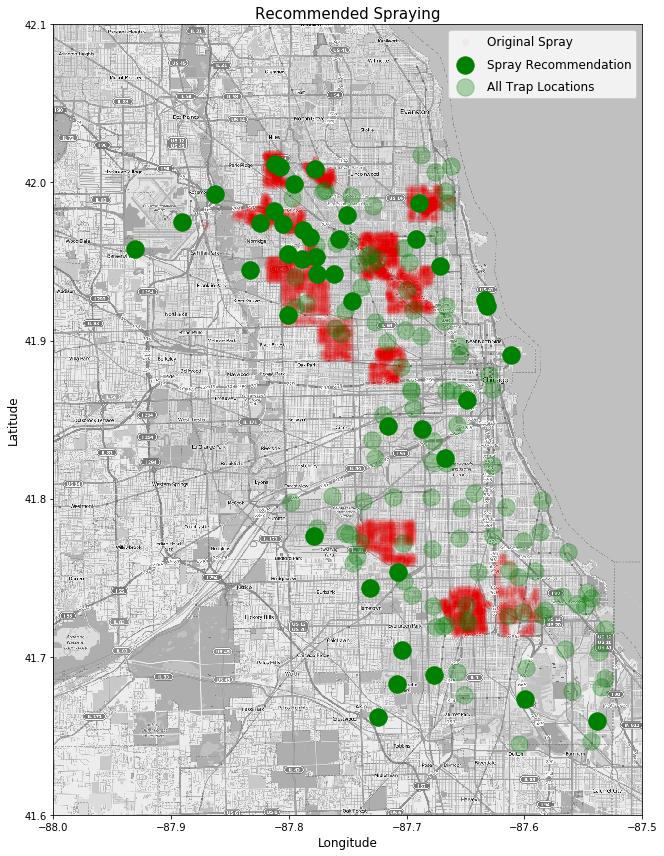

In [83]:
mapdata = np.loadtxt("../resources/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots(figsize=(20,7))
fig = plt.gcf()
fig.set_size_inches(16,12)
plt.title('Recommended Spraying', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

ax.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = df_spray[df_spray['longitude']>-88]
spray_locations_df = df_tp12[df_tp12['longitude']>-88]
orig_traps_df = df_test[df_test['longitude']>-88]
sprays = spray_df[['longitude', 'latitude']].drop_duplicates().values
targeted_sprays = spray_locations_df[['longitude', 'latitude']].drop_duplicates().values
original_traps = orig_traps_df[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=.03)
plt.scatter(targeted_sprays[:,0], targeted_sprays[:,1], c='g', s=300)
plt.scatter(original_traps[:,0], original_traps[:,1], c='g', alpha=.3, s=300)
plt.legend(['Original Spray', 'Spray Recommendation', 'All Trap Locations'], 
           loc='best', 
           fontsize=12, 
           fancybox=True,
           labelspacing=.8)

plt.tight_layout()
plt.savefig('../plots/12tp_50thresh.png')

#### 50 % True Positive Rate with 1.7 % Predict Proba Threshold (2014)

Taking a predict proba percentage of 1.7 % or more we can expect to have a true positive rate of 50 %

In [84]:
df_test['tp_50'] = df_test['pred_proba'].map(lambda x: 1 if x > .017 else 0)
df_test['tp_50'].value_counts()

0    70025
1    46268
Name: tp_50, dtype: int64

In [85]:
df_tp50 = df_test['2014'].query('tp_50 == 1')

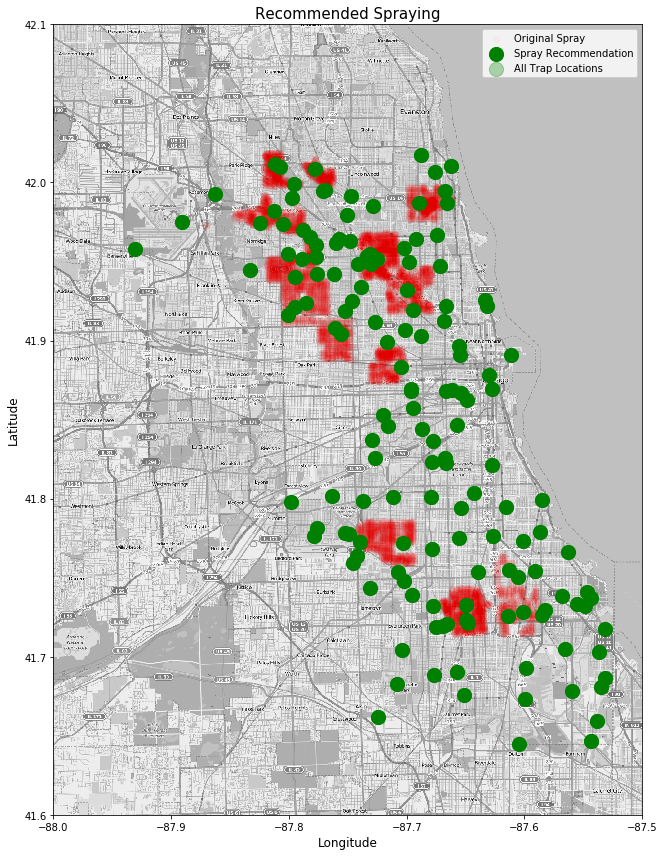

In [86]:
mapdata = np.loadtxt("../resources/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots(figsize=(20,7))
fig = plt.gcf()
fig.set_size_inches(16,12)
plt.title('Recommended Spraying', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

ax.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = df_spray[df_spray['longitude']>-88]
spray_locations_df = df_tp50[df_tp50['longitude']>-88]
orig_traps_df = df_test[df_test['longitude']>-88]

sprays = spray_df[['longitude', 'latitude']].drop_duplicates().values
targeted_sprays = spray_locations_df[['longitude', 'latitude']].drop_duplicates().values
original_traps = orig_traps_df[['longitude', 'latitude']].drop_duplicates().values

plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=.03)
plt.scatter(targeted_sprays[:,0], targeted_sprays[:,1], c='g', s=200)
plt.scatter(original_traps[:,0], original_traps[:,1], c='g', alpha=.3, s=200)
plt.legend(['Original Spray', 'Spray Recommendation', 'All Trap Locations'])

plt.tight_layout()
plt.savefig('../plots/50tp_17thresh.png')

#### 95 % True Positive Rate with 0.3 % Predict Proba Threshold (2014)

Taking a predict proba percentage of 0.3 % or more we can expect to have a true positive rate of 95 %

In [87]:
df_test['tp_95'] = df_test['pred_proba'].map(lambda x: 1 if x > .003 else 0)
df_test['tp_95'].value_counts()

1    64198
0    52095
Name: tp_95, dtype: int64

In [88]:
df_tp95 = df_test['2014'].query('tp_95 == 1')

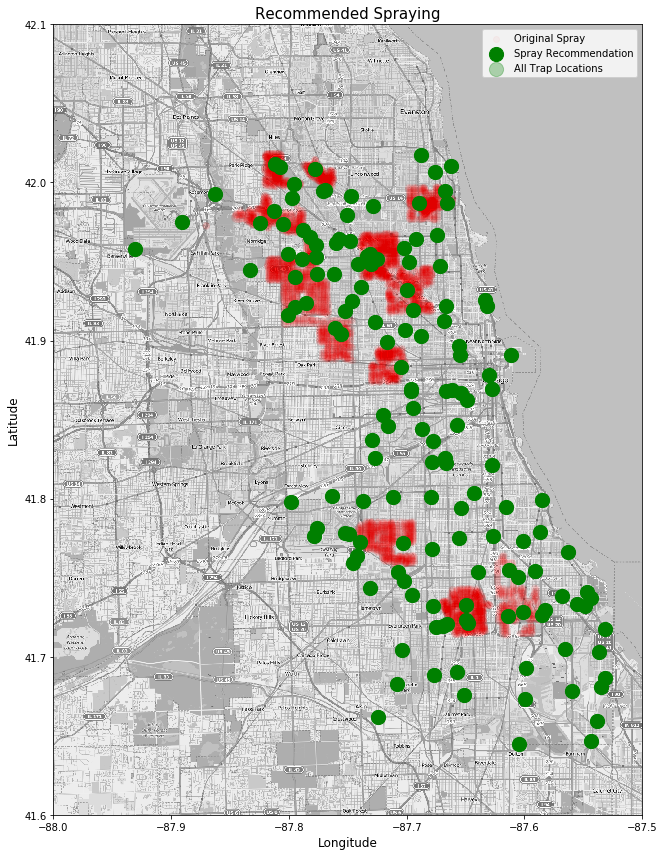

In [89]:
mapdata = np.loadtxt("../resources/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots(figsize=(20,7))
fig = plt.gcf()
fig.set_size_inches(16,12)
plt.title('Recommended Spraying', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

ax.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

spray_df = df_spray[df_spray['longitude']>-88]
spray_locations_df = df_tp95[df_tp95['longitude']>-88]
orig_traps_df = df_test[df_test['longitude']>-88]
sprays = spray_df[['longitude', 'latitude']].drop_duplicates().values
targeted_sprays = spray_locations_df[['longitude', 'latitude']].drop_duplicates().values
original_traps = orig_traps_df[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(sprays[:,0], sprays[:,1], c='r', alpha=.03)
plt.scatter(targeted_sprays[:,0], targeted_sprays[:,1], c='g', s=200)
plt.scatter(original_traps[:,0], original_traps[:,1], c='g', alpha=.3, s=200)
plt.legend(['Original Spray', 'Spray Recommendation', 'All Trap Locations'])

plt.tight_layout()
plt.savefig('../plots/95tp_03thresh.png')

#### Optimal time of Year to spray

To analzye the best time of year to spray mosquito pesticides we'll sum the predict probability values by date and focus on the most recent year of data we've been given (2014). This will display the times of years that have the highest predicted probabilities of WNV.

In [90]:
pred_proba_df = pd.DataFrame(df_test['2014'].groupby('date').sum()['pred_proba'])
pred_proba_df.head()

,pred_proba
date,
2014-06-05,0.122448
2014-06-12,0.063407
2014-06-19,0.157015
2014-06-26,0.304844
2014-07-03,0.099743


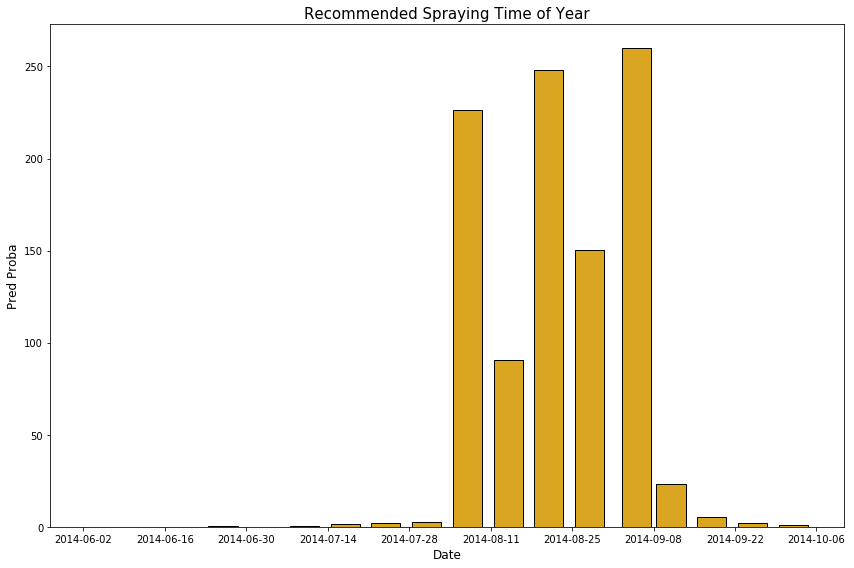

In [91]:
plt.figure(figsize=(12,8))
plt.title('Recommended Spraying Time of Year', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Pred Proba', fontsize=12)
plt.bar(pred_proba_df.index, pred_proba_df['pred_proba'].values, color='goldenrod', ec='k', width=5)

plt.tight_layout();
plt.savefig('../plots/pred_proba_month.png')